# (06) Align (across) -- lasso save

**Motivation**: Alignment scores (using lasso) across model classes only. Generate and save results. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# Code path
sys.path.insert(0, '/home/hadi/Documents/MTMST/code')
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
def _fit_lasso(
    x,
    y,
    x_tst,
    y_tst,
    alpha=0.02, ):
    
    shape = (y.shape[1], x.shape[1])
    importances = np.zeros(shape)
    
    mu_x = x.mean(0, keepdims=True)
    sd_x = x.std(0, keepdims=True)
    x = normalize_global(x, mu_x, sd_x)

    mu_y = y.mean(0, keepdims=True)
    sd_y = y.std(0, keepdims=True)
    y = normalize_global(y, mu_y, sd_y)

    lasso = sk_linear.Lasso(alpha=alpha).fit(x, y)
    pred = lasso.predict(normalize_global(x_tst, mu_x, sd_x))
    
    r2 = sk_metric.r2_score(
        y_pred=pred,
        y_true=normalize_global(y_tst, mu_y, sd_y),
        multioutput='raw_values',
    )
    return lasso, r2

## Setup

In [3]:
save_dir = pjoin(tmp_dir, 'alignment_rebuttal')
print(save_dir)

skip_fits = [
    'fixate1_nf-420_beta-0.8_(2023_05_07,04:15).npy',
]
path = pjoin(tmp_dir, 'trainer_analysis')
pal_model, pal_cat = get_palette()
category = 'fixate1'

/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

## Fit

In [4]:
%%time

# betas = [
#     0.01, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6,
#     0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 5.0, 10.0,
# ]

betas = [
    0.001, 0.1, 0.6, 0.7,
    0.8, 0.9, 2.0, 10.0,
]

for b in betas:
    files = sorted([
        f for f in os.listdir(path)
        if category in f and
        f"beta-{b}_" in f and
        f not in skip_fits
    ])
    
    data = {}
    for f in files:
        data[f] = np.load(
            file=pjoin(path, f),
            allow_pickle=True,
        ).item()

    for f1, f2 in itertools.combinations(files, 2):
        for src, tgt in [(f1, f2), (f2, f1)]:
            *_, b_src, m_src = extract_info(src)
            *_, b_tgt, m_tgt = extract_info(tgt)
            assert b_src == b_tgt

            x_vld = data[src]['data_vld']['z']
            x_tst = data[src]['data_tst']['z']
            y_vld = data[tgt]['data_vld']['z']
            y_tst = data[tgt]['data_tst']['z']
            
            lasso, r2 = _fit_lasso(
                x=x_vld,
                y=y_vld,
                x_tst=x_tst,
                y_tst=y_tst,
                alpha=0.02,
            )
            w = np.abs(lasso.coef_)
            w /= w.sum(1, keepdims=True)
            a = 1 - entropy_normalized(w, axis=1)

            results = {
                'a': a,
                'r2': r2,
                'w': w,
                'cond': f"{m_src} -> {m_tgt}",
                'metadata': {
                    'src': src,
                    'tgt': tgt,
                    'model_src': m_src,
                    'model_tgt': m_tgt,
                    'beta_src': b_src,
                    'beta_tgt': b_tgt},
                'kl_src': data[src]['loss']['kl_diag'],
                'kl_tgt': data[tgt]['loss']['kl_diag'],
            }
            fname = '_'.join([
                'lasso',
                f"src-{m_src}",
                f"tgt-{m_tgt}",
                f"beta-{b_src}",
            ])
            save_obj(
                obj=results,
                file_name=fname,
                save_dir=save_dir,
                verbose=True,
                mode='npy',
            )

[PROGRESS] 'lasso_src-cNVAE_tgt-VAE_beta-0.001.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

[PROGRESS] 'lasso_src-VAE_tgt-cNVAE_beta-0.001.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

[PROGRESS] 'lasso_src-cNVAE_tgt-VAE_beta-0.1.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

[PROGRESS] 'lasso_src-cNVAE_tgt-VAE_beta-0.6.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

[PROGRESS] 'lasso_src-VAE_tgt-cNVAE_beta-0.6.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.529e+01, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+01, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9

[PROGRESS] 'lasso_src-cNVAE_tgt-VAE_beta-0.7.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

[PROGRESS] 'lasso_src-VAE_tgt-cNVAE_beta-0.7.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

[PROGRESS] 'lasso_src-cNVAE_tgt-VAE_beta-0.8.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

[PROGRESS] 'lasso_src-VAE_tgt-cNVAE_beta-0.8.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

[PROGRESS] 'lasso_src-cNVAE_tgt-VAE_beta-0.9.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

<timed exec>:45: RuntimeWarning: invalid value encountered in true_divide


[PROGRESS] 'lasso_src-VAE_tgt-cNVAE_beta-0.9.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

[PROGRESS] 'lasso_src-cNVAE_tgt-VAE_beta-2.0.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

[PROGRESS] 'lasso_src-VAE_tgt-cNVAE_beta-2.0.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

[PROGRESS] 'lasso_src-cNVAE_tgt-VAE_beta-10.0.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

<timed exec>:45: RuntimeWarning: invalid value encountered in true_divide


[PROGRESS] 'lasso_src-VAE_tgt-cNVAE_beta-10.0.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp/alignment_rebuttal

CPU times: user 4d 14h 33min 31s, sys: 14d 23h 38min 27s, total: 19d 14h 11min 58s
Wall time: 13h 9min


In [5]:
w.sum(1)

array([1.        , 0.99999976, 1.0000002 , 1.0000001 ], dtype=float32)

In [6]:
fname

'src-cNVAE_tgt-VAE_beta-1.0_lasso'

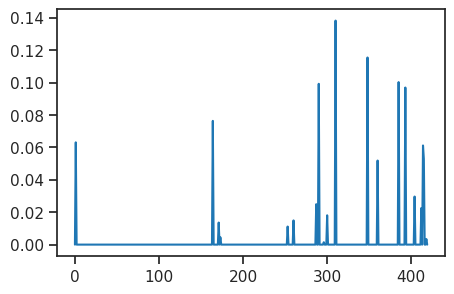

In [7]:
plt.plot(w[3]);

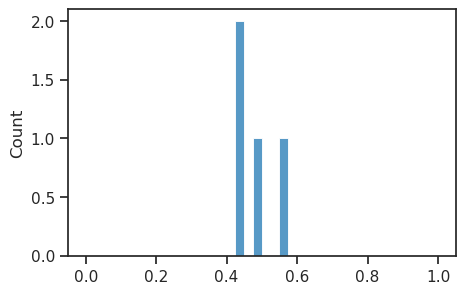

In [8]:
sns.histplot(a, bins=np.linspace(0, 1, 41));

In [9]:
r2

array([0.64444002, 0.45285117, 0.55075177, 0.047318  ])

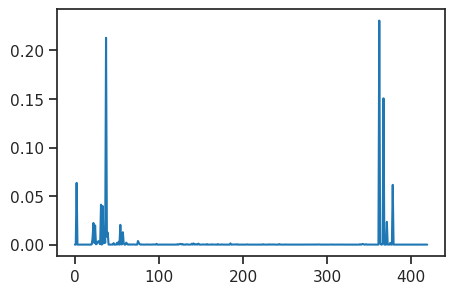

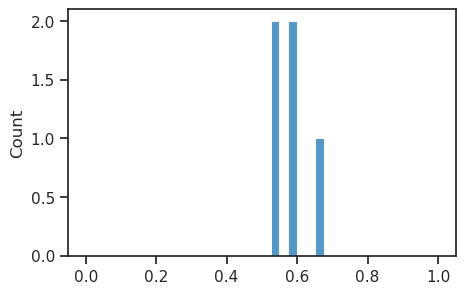

'src-cNVAE_tgt-VAE_beta-1.0_zscored'